# Discrete Link Transmission Model 

This library contain a set of code to use the computationally efficient link transmission model with some changes that allow to each vehicle to be tracked individually as well as demand with its associated routes. We also have implemented the implementation of the single commodity continuous link transmission model. We have plans to add the multi-commodity extension, but that is not implemented yet.

In this Notebook, we will be able to set a simulation up and to run a few examples.

There is also a folder with multiple samples with other examples. Not all have Notebooks with documentation fow now unfortunately (please contribute if you can!).

### attention: running the next cell is key to make sure all the enviroment is set up!

In [1]:
try:
    import pylab
except:
    print("pylab not found. Please install matplotlib")

from simulationengine.simulationRunner import SimulationRunner
from discrete.destinationNode import DestinationNode
from discrete.originNode import OriginNode
from discrete.link import Link
from discrete.divergeNode import DivergeNode
from discrete.mergeNode import MergeNode
from demand import trip


# How to set up the network

The network is a graph that has links and nodes as a common graph. This library follow the same principle of a general graph by which every link must have an upstram and a downstram node. Therefore, there is no link that acts a source link (with no upstream node and links starting at its upstream end) or as a destination link (with no donstream node with trips ending just at this link.). Here, a link whwere which trips starts have an OriginNode attached and links in which trip ends have a DestinationNode attached.

The Figure below show how a simple diverge-merge network is represented.


![Example network](resources/figures/network.png)

The circles represent nodes and are numbered from 1 to 4. The arrows represent the links and are also numbered from 1 to 4. The links have no distinct features in themselves, but the nodes do and we detail them below:

Node 1: source node (trips start from here) 

Node 2: diverge node (upstream link 1 and downstream links 2 and 3)

Node 3: merge node (upstream links 2 and 3 and downstream node 4)

Node 4: destination node (trips end here)

The following cell defines this network with some demand (node 1), turning rates (at node 2), merging priority (node 3)

In [2]:
link_1 = Link(link_id=1,length=300, kj=0.2, w=6.0, vf=30.0)
link_2 = Link(link_id=2,length=600, kj=0.2, w=6.0, vf=30.0)
link_3 = Link(link_id=3, length=300, kj=0.1, w=6.0, vf=30.0)
link_4 = Link(link_id=4, length=300, kj=0.1, w=6.0, vf=30.0)


trips = trip.Trip.from_continuous_demand([0.5, 0.8, 0.2],600,route=None,
                                         route_integer_share={(1,2,4): 1, (1,3,4): 2},random_route=False)

origin_node = OriginNode(node_id=1, link=link_1, demand_trips=trips)
diverge_node = DivergeNode(node_id=2, inbound_link=link_1, outbound_links=[link_2, link_3])
merge_node = MergeNode(node_id=3, inbound_links=[link_2, link_3], outbound_link=link_4, priority_vector=[0,1,0,1,0,1])
destination_node = DestinationNode(node_id=4,link=link_4)

links = [link_1, link_2, link_3, link_4]
nodes = [origin_node, diverge_node, merge_node, destination_node]

runner = SimulationRunner(links=links, nodes=nodes, time_step=1.0, total_time=600.0)


In [3]:
runner.run()
print("simulation complete!")

simulation complete!


We've done it! The simulation is completed. Now we can look for the outputs to make sure they look fine.

Since we have only 4 links, we will plot a giant graph with the cumulative inflow and outflow curves for each link on the same graph.

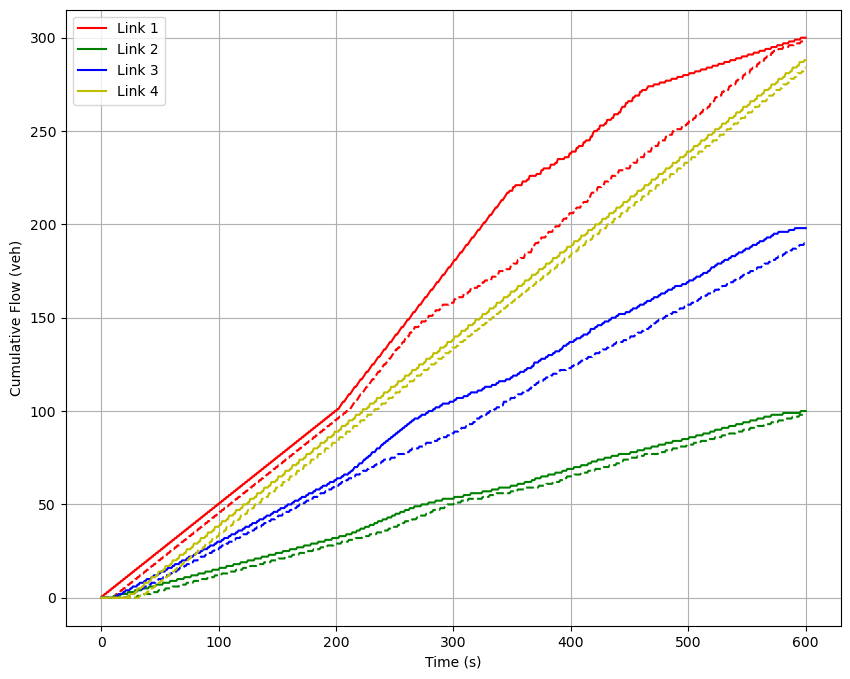

In [4]:
f, axs = pylab.subplots(1, 1, figsize=(10,8))

colors = ['r', 'g', 'b', 'y']

for u, link in enumerate(runner.links):
    axs.plot(runner.get_times(1), link.cumulative_inflows, color=colors[u], label=f'Link {link.link_id}')
    axs.plot(runner.get_times(1), link.cumulative_outflows, color=colors[u],
             linestyle='--')
axs.set_xlabel('Time (s)')
axs.set_ylabel('Cumulative Flow (veh)')
axs.grid(True)
axs.legend()
pylab.show()

There it is our simple simulation. The demand over the 600s introduced 300 vehicles in the network. All vehicles cross links 1 and 4 and we can see that these two links reach almost 300 vehicles in their cumulative inflow and outflow.

Between links 1 and 2, we made the route choice split in the ratio 2/1 and we can see the cumulative flows also follow these 2 to 1 ratio (200veh to 100veh by the end of the simulation). 

Link 2 has higher capacity and lower demand than link 3 and we can see it does not experience congestion. Link 3 is the opposite with some congestion (based on the distance between the cumulatives) occurring after t=200s. Link 1 also cannot discharge all vehicles to link 2 after that time and also experience some congestion.

# Deriving metrics: measuring route choice impact.

From the cumulative curves and the waiting queue in the origin nodes we can compute different metrics. Here, we will compute the total time spent for two different route choices. We will now define a function that define the scenario and returns the simulation object given two inputs: the ratio in the route choice. 

This scenario will have only a small change in the network related to the link 4 capacity (jam density from 0.1 to 0.15).

In [5]:
def run_for_route_choice_ratios(ratio_2, ratio_3):
    link_1 = Link(link_id=1,length=300, kj=0.2, w=6.0, vf=30.0)
    link_2 = Link(link_id=2,length=600, kj=0.3, w=6.0, vf=30.0)
    link_3 = Link(link_id=3, length=300, kj=0.2, w=6.0, vf=30.0)
    link_4 = Link(link_id=4, length=300, kj=0.1, w=6.0, vf=30.0)


    trips = trip.Trip.from_continuous_demand([0.5, 0.7, 0.2],600,route=None,
                                            route_integer_share={(1,2,4): ratio_2, (1,3,4): ratio_3}
                                            ,random_route=False)

    origin_node = OriginNode(node_id=1, link=link_1, demand_trips=trips)
    diverge_node = DivergeNode(node_id=2, inbound_link=link_1, outbound_links=[link_2, link_3])
    merge_node = MergeNode(node_id=3, inbound_links=[link_2, link_3], outbound_link=link_4, priority_vector=[0,1,0,1,0])
    destination_node = DestinationNode(node_id=4,link=link_4)

    links = [link_1, link_2, link_3, link_4]
    nodes = [origin_node, diverge_node, merge_node, destination_node]

    runner = SimulationRunner(links=links, nodes=nodes, time_step=1.0, total_time=600.0)
    runner.run()
    return runner

The code above creates the simulation runner, runs and return the simulation object. Now we need to derive the total time spent in the network. For that we will define a function that gets a simulation runner and compute the total time spent. 

We will use the cumulative flows on the links. The differece between cumulative inflow and cumulative outflow is the number of vehicles in the link. We also need to add the time queued in the origin node.

In [6]:
def compute_tts(runner):
    tts = 0
    for link in runner.links:
        for t in range(len(link.cumulative_inflows)):
            tts += (link.cumulative_inflows[t] - link.cumulative_outflows[t])*link.time_step

    origin_node = runner.nodes[0]
    tts += sum(origin_node.entry_queue)*origin_node.time_step
    return tts

Now let's set different route choice shares and plot a graph with the total time spent for each share.

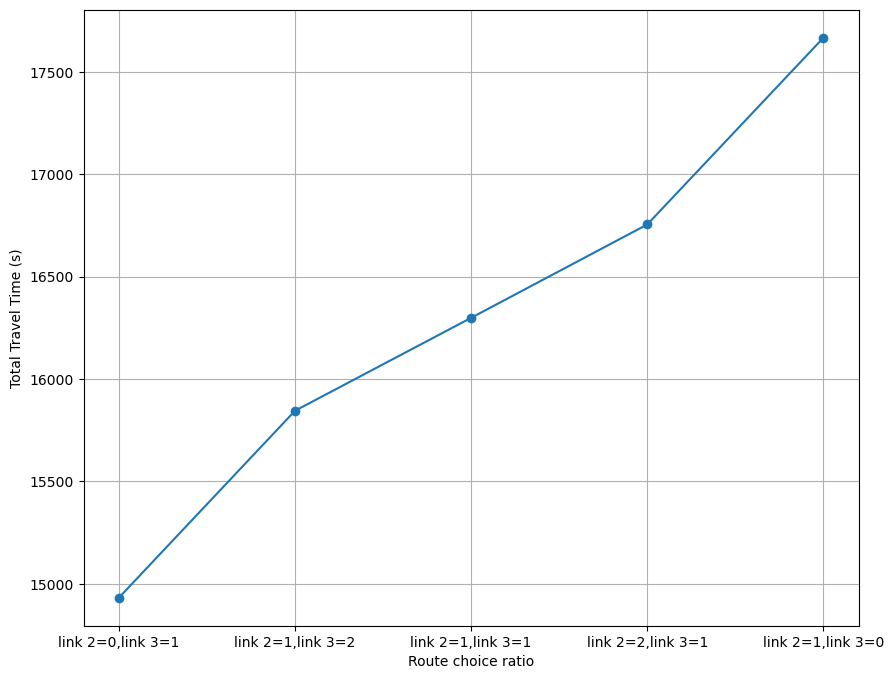

In [7]:
ratios = [(0, 1), (1, 2), (1, 1), (2, 1),(1, 0)]

ttss = []
for ratio in ratios:
    runner = run_for_route_choice_ratios(ratio[0], ratio[1])
    tts = compute_tts(runner)
    ttss.append(tts)

f, axs = pylab.subplots(1, 1, figsize=(10,8))
axs.plot([f'link 2={ratio[0]},link 3={ratio[1]}' for ratio in ratios], ttss, 'o-')
axs.set_xlabel('Route choice ratio')
axs.set_ylabel('Total Travel Time (s)')
axs.grid(True)
pylab.show()

## Route choice and potential use of Dynamic Traffic Assignment
As we can see, the more we push vehicles into link 3 the lower is the travel time. This is expected as link 3 has more capacity and can discharge more vehicles in this scenario in which the bottleneck is the entrance to link 4.

Nevertheless, this has nothing to do with how vehicles would chose their routes. Most of the transportation field assumes (or attempts to as it is not an easy implementation!) the User Equilibrium proposed by Wardrop. The UE means that all used routes for a particular origin-destination must yield the same travel time for all users as otherwise some drivers will have shifted their routes to decrease their own travel times. This also means a first-in-first-out at a given OD.



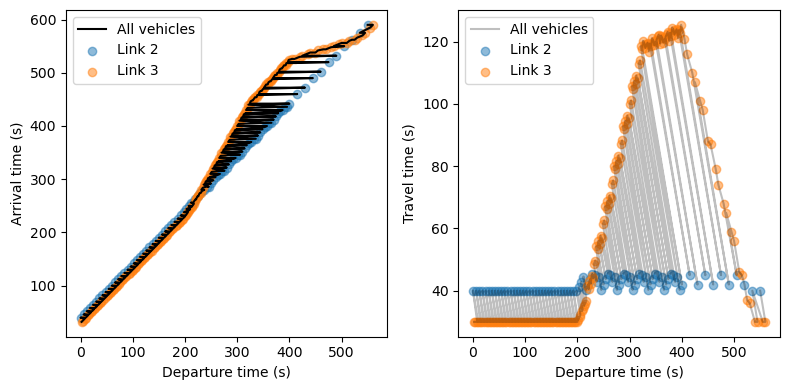

In [8]:
runner = run_for_route_choice_ratios(1, 2)

link_2_trips = [veh for veh in runner.nodes[3].arrived_vehicles if veh.route == (1, 2, 4)]
link_3_trips = [veh for veh in runner.nodes[3].arrived_vehicles if veh.route == (1, 3, 4)]

f, axs = pylab.subplots(1, 2, figsize=(8,4))
axs[0].plot([veh.start for veh in runner.nodes[3].arrived_vehicles],
          [veh.end for veh in runner.nodes[3].arrived_vehicles], label='All vehicles', color='black')
axs[0].scatter([veh.start for veh in link_2_trips], [veh.end for veh in link_2_trips], label='Link 2', alpha=0.5)
axs[0].scatter([veh.start for veh in link_3_trips], [veh.end for veh in link_3_trips], label='Link 3', alpha=0.5)
axs[0].legend()
axs[0].set_xlabel("Departure time (s)")
axs[0].set_ylabel("Arrival time (s)")

axs[1].plot([veh.start for veh in runner.nodes[3].arrived_vehicles],
          [veh.end-veh.start for veh in runner.nodes[3].arrived_vehicles], label='All vehicles', color='black',alpha=0.25)
axs[1].scatter([veh.start for veh in link_2_trips], [veh.end-veh.start for veh in link_2_trips], label='Link 2', alpha=0.5)
axs[1].scatter([veh.start for veh in link_3_trips], [veh.end-veh.start for veh in link_3_trips], label='Link 3', alpha=0.5)
axs[1].legend()
axs[1].set_xlabel("Departure time (s)")
axs[1].set_ylabel("Travel time (s)")
pylab.tight_layout()
pylab.show()

This fixed assignment violates User Equilibrium. In the graph above, we plotted the arrival times for all vehicles (connected by lines) with the colored dots representing vehicles in each route in the left. In the right, we plot the travel time in each route based on the arrival time of vehicles in each route. As we can see, before the congestion going throgh link 3 is advantageous, but once congestion ensues using the higher capacity link 2 becomes the best decision for this particular route shares.

In purpose we use a plot and not a scatter to plot for all vehicles. If FIFO was respected, the graph would be strictly increasing and the plot would look like a straight line and there wouldn't be space between orange and blue dots. To solve it, we need time-dependent route shares by using a proper Dynamic Traffic Assignment (DTA) algorithm.

# Summary

This was a quick guide on how to use the ABM-MESO. Here is a quick recap:

- Network described as a list of links and nodes. Nodes contain references to its inbound and outbound links.
- Links always connect two nodes
- Trips start at OriginNode and ends at a DestinationNode